# Notebook Model v.2

## Content:
1. [Imports](#Imports)
2. [Read data](#Read_data)
3. [Modelling](#Modelling)
4. [Model variable choices](#Model_var_choices)
5. [Results](#Results)


## Summary
Given a football player $u$ with KPI data created from match event data and team possession data, we want to detect its playing style $y(pos_{u})$, where $y(pos_{u}) \in \{y_{1}(pos), \dots, y_{n(pos)}(pos)\}$ with $pos \in \{ST, CM, OW, FB, CB\}$. Here $n(pos)$ is the number of playing styles for position $pos$. 

Together with finding the playing style for player $u$, we also want the model to be able to tell us how much player $u$ correlates to each found playing style for each position. Thus, given a football player $u$ with match event data, KPI data and team possession data, we want to detect its playing style correlation vector $\mathbf{y}_{u}$, with vector length of $\sum_{pos \in \{ST, CM, OW, FB, CB\}} n(pos)$. 

Combining the two above explained problem formulations, we have a regression problem where we want to find the playing style correlation vector $\mathbf{y}_{u}$ for all available players $\mathbf{u}$. For each player $u$, the playing style $y(pos_{u})$ can then be found from the highest correlation weight in $\mathbf{y}_{u}$ belonging to position $pos_{u}$.

## 1. Imports <a class="anchor" id="Imports"></a>

In [1]:
# Basics
import pandas as pd

# Project module
import modules.validation_lib as validate
from modules.config import dict_playingStyle_indices, list_all_playingStyle_indices
from modules.models_lib import create_PCA_scores, map_PCA_scores
import modules.viz_lib as viz

## 2. Read data <a class="anchor" id="Read_data"></a>

As inputs to the model there is the processed and filtered KPI-data found in the data directory. 
Note here that positions computed from the position detection model already exists in these imported .xlsx-files.

In [2]:
# Read model KPI dataframe from PL
df_KPI_PL = pd.read_excel('../data/model_kpis_PL21-22.xlsx')

# Read model KPI dataframe from Allsvenskan, Sweden
df_KPI_Swe = pd.read_excel('../data/model_kpis_Swe21.xlsx')


## 3. Modelling <a class="anchor" id="Modelling"></a>

### 3.1 PCA
The model approach used was an unsupervised PCA-based model. By letting the data sort of speak for itself and by interpreting the emerging results we could find out whether or not the playing styles in the hypothesis did in fact exist and which players were classified within the respective found playing styles.

For the function "create_PCA_scores" (which is the main-function of the developed model), it is important to understand the different inputs as well as the different dataframes in the output dictionary. 

The first input, "df_KPI_train", is what actually creates the principal components of the model. Thus, the "results_weights"-output reflects the weights of the train-data. The second input, "df_KPI_test", is the test-data of the model which PCA-scores are computed for. Note here that since the model is unsupervised we can also use the scores from the train-data for our results. 

Two of the output dataframes are named "excl". In those dataframes resulting PCA-scores for players in other position than the detected one exists. These scores have been normalized outside of the actual players within that position to not interfere with the results for the playing style results withoin that position. 


In [3]:
# Get PCA-scores
dict_PCA_result = create_PCA_scores(df_KPI_PL, df_KPI_Swe, screeplot=False, nr_of_PCs=6)

# Result collecting
df_result_weights = dict_PCA_result['result_weights']
df_result_PCA_PL = dict_PCA_result['result_train']
df_result_PCA_PL_excl = dict_PCA_result['result_excl_train']
df_result_PCA_Swe = dict_PCA_result['result_test']
df_result_PCA_Swe_excl = dict_PCA_result['result_excl_test']

### 3.2 Result mapping
The mapping consist of looking at the principal component weight patterns and scree plots with the goal of finding playing styles within the data. These playing styles should both be reflected by the weight patterns and also be recognizable by an "ordinary" football enthusiast.

#### 3.2.1 Example mapping
Plot PCA weights and analyze. Choose which PCs to look at (one or several, inverted or not).

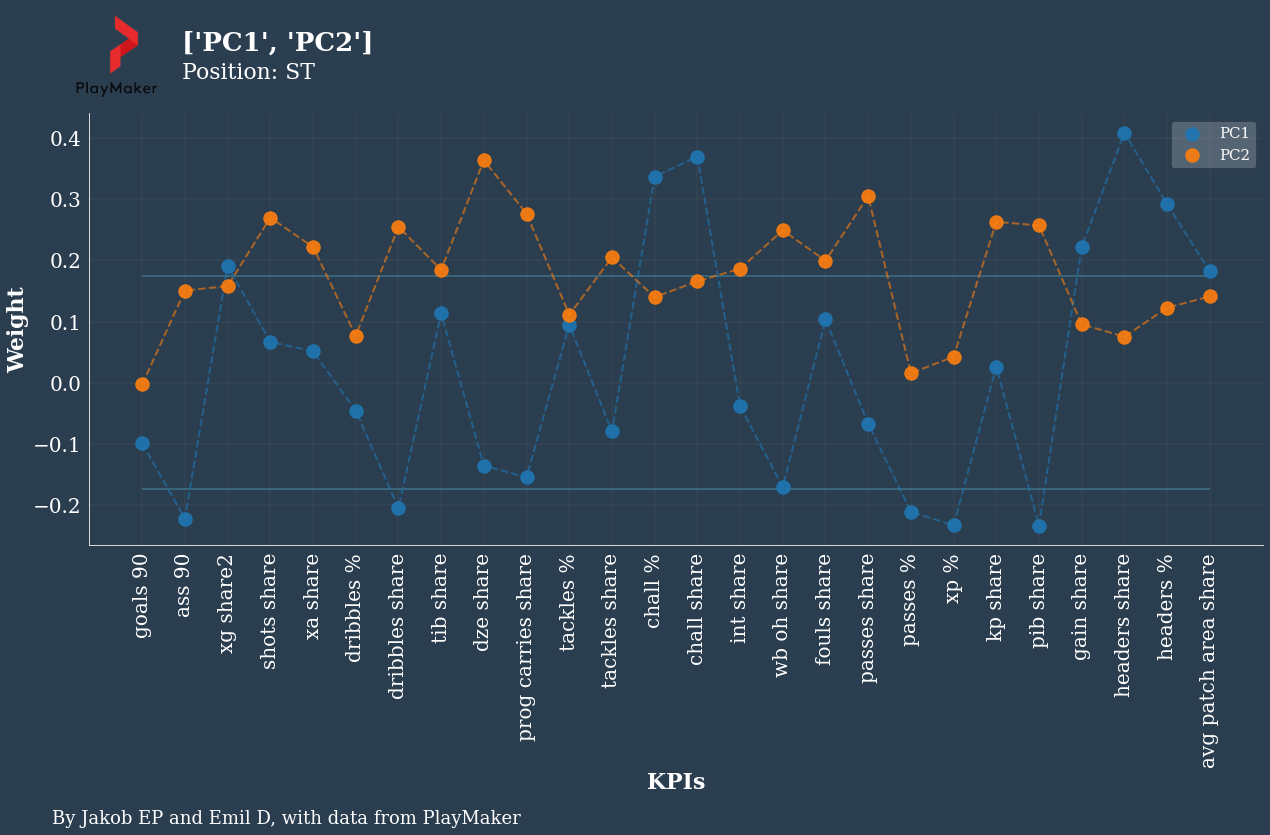

In [4]:
# Plot inputs
position_var = 'ST'
PCs_to_plot = ['PC1', 'PC2',]

viz.plot_PCA_weights(df_result_weights, position_var, PCs_to_plot, inverted=False,
                     logo_path="../figures_used/Playmaker_Logo.png",
                     show_legend=True)

From looking at multiple similar shown PC KPI-weights we can create the following mapper:

In [5]:

# Example (Make sure to include each position ['ST', 'CM', 'OW', 'FB', 'CB'] as keys)
# Currently same as in config.py (which is needed for useful validation results)
dict_playingStyle_example_mapper = {
    'ST': {
        'PC1': {
            'playing_style': "The Target",
            'inverted': False,
            },
        'PC2': {
            'playing_style': "The Artist",
            'inverted': False,
            },
        'PC3': {
            'playing_style': "The Worker",
            'inverted': False,
            },
        'PC4': {
            'playing_style': "The Poacher",
            'inverted': False,
            },
        },
    'CM': {
        'PC1': {
            'playing_style': "The Anchor",
            'inverted': True,
            },
        'PC2': {
            'playing_style': "The Playmaker",
            'inverted': False,
            },
        'PC4': {
            'playing_style': "The Box-to-box",
            'inverted': False,
            },
        },
    'OW': {
        'PC1': {
            'playing_style': "The Star",
            'inverted': True,
            },
        'PC2': {
            'playing_style': "The 4-4-2-fielder",
            'inverted': False,
            },
        'PC5': {
            'playing_style': "The Solo-dribbler",
            'inverted': False,
            },
        },
    'FB': {
        'PC1': {
            'playing_style': "The Winger",
            'inverted': False,
            },
        'PC2': {
            'playing_style': "The Inverted",
            'inverted': False,
            },
        'Other': {
            'PC': 'PC1',
            'playing_style': "The Defensive-minded",
            'inverted': True,
            },
        },
    'CB': {
        'PC1': {
            'playing_style': "The Leader",
            'inverted': False,
            },
        'PC3': {
            'playing_style': "The Low-risk-taker",
            'inverted': False,
            },

        'Other': {
            'PC': 'PC2',
            'playing_style': "The Physical",
            'inverted': True,
            }
        }
    }

#### 3.2.2 Mapping of all players (see function)

In [6]:
# Map scores to playingstyles
df_playing_styles_PL = map_PCA_scores(df_result_PCA_PL, df_result_PCA_PL_excl, dict_mapper=dict_playingStyle_example_mapper)
df_playing_styles_Swe = map_PCA_scores(df_result_PCA_Swe, df_result_PCA_Swe_excl, dict_mapper=dict_playingStyle_example_mapper)

## 4. Model variable choices <a class="anchor" id="Model_var_choices"></a>
### 4.1 Inputs

In [7]:
# Choose position to 
set_position = 'ST'

# Choose league (uncomment which to use)
#league = 'PL'
#league = 'Swe'
league = 'both'

### 4.2 Handle inputs 
Handles inputs for which league/leagues to show confusion matrix for.


In [8]:
df_playing_style = pd.DataFrame()
if league == 'PL':
    df_playing_style = df_playing_styles_PL
elif league == 'Swe':
    df_playing_style = df_playing_styles_Swe
elif league == 'both':
    df_playing_style = pd.concat([df_playing_styles_PL, df_playing_styles_Swe])
else: 
    print("WRONG INPUT")

## 5. Results <a class="anchor" id="Results"></a>
To be able to validate against the validation data in the 'data'-folder, the mapper in section 3.2.1 needs to follow the same conventions as the validation data. This means that if other playing styles (than in the validation data set) were to be found, a new validation data set with those found playing styles will need to be created and validated against. 

### 5.1 Reformatting and position filtering

In [9]:
# Replace to validation index formatting
df_playing_style.replace({"The Target": 1.1, "The Poacher": 1.2, "The Artist": 1.3, "The Worker": 1.4,
                            "The Box-to-box": 2.1, "The Playmaker": 2.2, "The Anchor": 2.3,
                            "The Solo-dribbler": 3.1, "The 4-4-2-fielder": 3.2, "The Star": 3.3,
                            "The Winger": 4.1, "The Defensive-minded": 4.2, "The Inverted": 4.3,
                            "The Leader": 5.1, "The Low-risk-taker": 5.2, "The Physical": 5.3}, inplace = True)

# Filter by the set position
df_playingS_result_pos = df_playing_style[df_playing_style['Position'] == set_position]

### 5.2 Compute confusion matrix

In [10]:
# Compare detected playing styles to validation data
dict_validation_results_pos = validate.create_validation_dataframes(
    df_playingS_result_pos, "Player_name", "name",
    'Playing-style_primary',
    'Playing-style',
    position=set_position)

# Find the resulting dataframe from the dictionary
df_result = dict_validation_results_pos['df_result']
df_correct = dict_validation_results_pos['df_correct']
df_incorrect = dict_validation_results_pos['df_incorrect']

# Drop players from result which dont match with validation position 
df_result = df_result[df_result['actual_class'].isin(dict_playingStyle_indices[set_position])]

# Compute the confusion matrix
df_conf = validate.confusion_matrix(df_result, dict_playingStyle_indices[set_position], 'predicted_class', 'actual_class', show_results=True)


+------------+-------+-------+-------+-------+-----------+
|            |   1.1 |   1.2 |   1.3 |   1.4 |   #actual |
+============+=======+=======+=======+=======+===========+
| 1.1        |    20 |     0 |     2 |     1 |        23 |
+------------+-------+-------+-------+-------+-----------+
| 1.2        |     4 |    22 |     4 |     1 |        31 |
+------------+-------+-------+-------+-------+-----------+
| 1.3        |     0 |     1 |    17 |     0 |        18 |
+------------+-------+-------+-------+-------+-----------+
| 1.4        |     3 |     0 |     3 |    13 |        19 |
+------------+-------+-------+-------+-------+-----------+
| #predicted |    27 |    23 |    26 |    15 |        91 |
+------------+-------+-------+-------+-------+-----------+


### 5.3 Compute and show class metrics 

In [11]:
# Compute and show class metrics
print(f"Class metrics for playing style position {set_position}: \n")
df_class_metrics_pos = validate.confusion_matrix_class_metrics(df_conf, dict_playingStyle_indices[set_position], show_results=True)

Class metrics for playing style position ST: 

Total accuracy: 0.79
+-----+-------------+----------+---------------+------------+
|     |   precision |   recall |   specificity |   F1-score |
+=====+=============+==========+===============+============+
| 1.1 |        0.87 |     0.74 |          0.95 |       0.8  |
+-----+-------------+----------+---------------+------------+
| 1.2 |        0.71 |     0.96 |          0.87 |       0.81 |
+-----+-------------+----------+---------------+------------+
| 1.3 |        0.94 |     0.65 |          0.98 |       0.77 |
+-----+-------------+----------+---------------+------------+
| 1.4 |        0.68 |     0.87 |          0.92 |       0.76 |
+-----+-------------+----------+---------------+------------+
